In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-e1hi0cxj
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-e1hi0cxj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730117 sha256=4464d3f76a9e5ed73d62f98a76c36d52039db057584ec223046212a42921355d
  Stored in directory: /tmp/pip-ephem-wheel-cache-i21q9gk7/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
  Found existing installation: altair 4.1.0
    Uninstalling altair-4.1.0:
      Successfully uninstalled altair-4.1.0
Done installing Altair.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/CA4015/Assignment_4/')
#os.chdir('/content/drive/My Drive/College - 4th Year/CA4015_AdvancedML/Assignment_4/') # Liam

## Section II - Preliminaries

In [ ]:
def build_rating_sparse_tensor(user_artists_df):
  """
  Args:
    user_artists_df: a pd.DataFrame with `user_id`, `artist_id` and `weight`(represents no.of times user has listened to artist) columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """

  indices = user_artists_df[['userID', 'artistID']].values
  values = user_artists_df['weight'].values

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(user_artists.userID.unique()), artists.shape[0]])
  
      #shape is the unique number of users and artists

In [ ]:
user_artists = pd.read_csv('data_clean/new_user_artists.csv')
user_friends = pd.read_csv('data_clean/user_friends.csv')
u_t_artists = pd.read_csv('data_clean/u_t_artists.csv')
uta_timestamps = pd.read_csv('data_clean/uta_timestamps.csv')
artists = pd.read_csv('data_clean/artists.csv')
tags = pd.read_csv('data_clean/tags.csv')

In [ ]:
#@title  { display-mode: "code" }
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

## Section III - Training Factorization Model

In [ ]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "userID": U,
      "artistID": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
user_artists

Unnamed: 0  userID  artistID  new_weight
0               0    1859       429           1
1               1     229      4553           1
2               2     229      4552           1
3               3     229      4551           1
4               4     229      2905           1
...           ...     ...       ...         ...
92829       92829       5         5           5
92830       92830       5         5           5
92831       92831       5         5           5
92832       92832       5         5           5
92833       92833       5         5           5

[92834 rows x 4 columns]

In [ ]:
user_artists = user_artists[['userID', 'artistID', 'weight']]

In [ ]:
user_artists['userID'] = user_artists['userID'].astype(str)
user_artists['artistID'] = user_artists['artistID'].astype(str)
user_artists['weight'] = user_artists['weight'].astype(float)
user_artists = user_artists.sample(frac=1).reset_index(drop=True)

In [ ]:
user_artists = user_artists.sort_values(by=['userID'])

In [ ]:
user_artists['alt_userID'] = int

Next block will map user IDs to range from 0 to length of unique users, required for model, not well optimised so takes a few mins to run

In [ ]:
i = 0
j = 0
while i < len(user_artists)-1:
  if user_artists.userID.iloc[i] == user_artists.userID.iloc[i+1]:
    user_artists.alt_userID.iloc[i] = j
    i = i + 1
  else:
    user_artists.alt_userID.iloc[i] = j
    i = i + 1
    j = j + 1
user_artists.alt_userID.iloc[i] = j

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
user_artists = user_artists[['alt_userID', 'artistID', 'weight']]

In [ ]:
user_artists = user_artists.rename(columns={"alt_userID": "userID"})

In [ ]:
user_artists = user_artists.sort_values(by=['artistID'])
user_artists['alt_artistID'] = int

Next block will map artist IDs to range from 0 to length of unique artists, required for model, not well optimised so takes a few mins to run

In [ ]:
i = 0
j = 0
while i < len(user_artists)-1:
  if user_artists.artistID.iloc[i] == user_artists.artistID.iloc[i+1]:
    user_artists.alt_artistID.iloc[i] = j
    i = i + 1
  else:
    user_artists.alt_artistID.iloc[i] = j
    i = i + 1
    j = j + 1
user_artists.alt_artistID.iloc[i] = j

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
user_artists = user_artists[['userID', 'alt_artistID', 'weight']]
user_artists = user_artists.rename(columns={"alt_artistID": "artistID"})

In [ ]:
backup = user_artists

In [ ]:
user_artists = backup

In [ ]:
user_artists['userID'] = user_artists['userID'].astype(str)
user_artists['artistID'] = user_artists['artistID'].astype(str)
user_artists['weight'] = user_artists['weight'].astype(float)
user_artists = user_artists.sample(frac=1).reset_index(drop=True)

In [ ]:
user_artists

userID artistID   weight
0        878     7521   62.000
1       1444     6696   45.000
2        166    17597    3.000
3       1469    15702   78.000
4         70    10951  324.000
...      ...      ...      ...
92829   1751    16623 1247.000
92830   1211    12659 4954.000
92831   1152      407   63.000
92832   1605    17043    3.000
92833   1013    15907  380.000

[92834 rows x 3 columns]

In [ ]:
user_artists = user_artists.sort_values(by=['weight'])

In [ ]:
user_artists['alt_weight'] = float

In [ ]:
min_weight = min(user_artists.weight)
max_weight = max(user_artists.weight)

for i in range(0,len(user_artists)):
  user_artists.alt_weight.iloc[i] = np.interp(user_artists.weight.iloc[i],[min_weight,max_weight],[0,5])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
user_artists = user_artists[['userID', 'artistID', 'alt_weight']]
user_artists = user_artists.rename(columns={"alt_weight": "weight"})

Doesn't like 0 as a rating, so making anything less than 1 a 1 for now

In [ ]:
for i in range(0,len(user_artists)):
  if user_artists.weight.iloc[i] <= 1:
    user_artists.weight.iloc[i] = float(1.00)

In [ ]:
user_artists['userID'] = user_artists['userID'].astype(str)
user_artists['artistID'] = user_artists['artistID'].astype(str)
user_artists['weight'] = user_artists['weight'].astype(float)
user_artists = user_artists.sample(frac=1).reset_index(drop=True)

 iteration 1000: train_error=0.047173, test_error=1.172596

[{'test_error': 1.1725956, 'train_error': 0.04717258}]

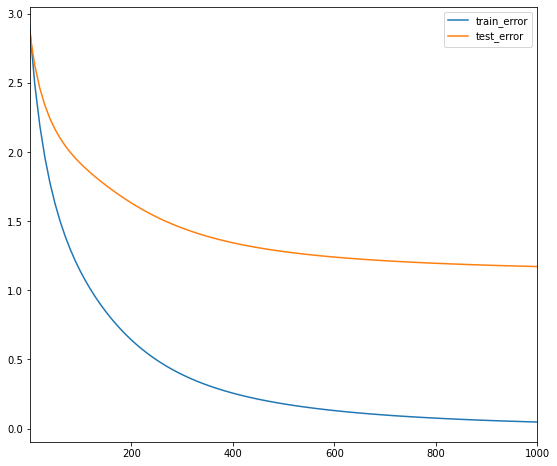

In [ ]:
# Build the CF model and train it.
model = build_model(user_artists, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

There is a new csv called new_user_artists which has weights organised into 5 equal buckets with ratings between 1 and 5 based on their original weight.

## Section IV - Inspect Embeddings

In [ ]:
#@title Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  artists[artists['name'].str.contains(title_substring)].index.values
  titles = artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
artist_neighbors(model, "The Weeknd", DOT)
artist_neighbors(model, "The Weeknd", COSINE)
artist_neighbors(model, "Oasis", DOT)
artist_neighbors(model, "Oasis", COSINE)

Nearest neighbors of : The Weeknd.


dot score                   names
5767      7.074              The Weeknd
6894      4.872                Klamydia
4863      4.773  CCCP Fedeli alla linea
9945      4.653          Kaname Kawachi
1860      4.539                      D2
1508      4.409             The Wombats

Nearest neighbors of : The Weeknd.


cosine score                   names
5767          1.000              The Weeknd
4863          0.660  CCCP Fedeli alla linea
16745         0.652                    堀江由衣
8697          0.642              El-Creepo!
2952          0.629                Star One
1508          0.616             The Wombats

Nearest neighbors of : Oasis.


dot score            names
527        5.330            Oasis
10795      5.112           Khaled
16875      4.522      Corey Smith
10981      4.370  Мирбек Атабеков
8340       4.259          AMBIREP
15958      4.215           Dil Se

Nearest neighbors of : Oasis.


cosine score                names
527           1.000                Oasis
16875         0.669          Corey Smith
7324          0.645                   EU
15704         0.609                Triad
12921         0.603       The Lucksmiths
2384          0.602  The Lovely Feathers

In [ ]:
pd.set_option('display.max_rows', None)
artists

Unnamed: 0  ...                                         pictureURL
0               0  ...    http://userserve-ak.last.fm/serve/252/10808.jpg
1               1  ...  http://userserve-ak.last.fm/serve/252/3052066.jpg
2               2  ...  http://userserve-ak.last.fm/serve/252/40222717...
3               3  ...  http://userserve-ak.last.fm/serve/252/54697835...
4               4  ...  http://userserve-ak.last.fm/serve/252/14789013...
5               5  ...  http://userserve-ak.last.fm/serve/252/2181591.jpg
6               6  ...  http://userserve-ak.last.fm/serve/252/2558217.jpg
7               7  ...  http://userserve-ak.last.fm/serve/252/46968835...
8               8  ...  http://userserve-ak.last.fm/serve/252/51273485...
9               9  ...  http://userserve-ak.last.fm/serve/252/5872875.jpg
10             10  ...  http://userserve-ak.last.fm/serve/252/31693309...
11             11  ...  http://userserve-ak.last.fm/serve/252/54196161...
12             12  ...  http://userserve-ak.last.fm/serve/252/34892635...
13             13  ...  http://userserve-ak.last.fm/serve/252/52216127...
14             14  ...  http://userserve-ak.last.fm/serve/252/5364091.jpg
15             15  ...  http://userserve-ak.last.fm/serve/252/35246025...
16             16  ...  http://userserve-ak.last.fm/serve/252/10323129...
17             17  ...   http://userserve-ak.last.fm/serve/252/541326.jpg
18             18  ...  http://userserve-ak.last.fm/serve/252/29314111...
19             19  ...  http://userserve-ak.last.fm/serve/252/17969009...
20             20  ...  http://userserve-ak.last.fm/serve/252/5297893.jpg
21             21  ...  http://userserve-ak.last.fm/serve/252/8058051.jpg
22             22  ...  http://userserve-ak.last.fm/serve/252/17291471...
23             23  ...  http://userserve-ak.last.fm/serve/252/30799583...
24             24  ...  http://userserve-ak.last.fm/serve/252/8193963.jpg
25             25  ...   http://userserve-ak.last.fm/serve/252/615172.jpg
26             26  ...  http://userserve-ak.last.fm/serve/252/35522943...
27             27  ...  http://userserve-ak.last.fm/serve/252/50818861...
28             28  ...  http://userserve-ak.last.fm/serve/252/23951523...
29             29  ...  http://userserve-ak.last.fm/serve/252/59793013...
30             30  ...   http://userserve-ak.last.fm/serve/252/371747.jpg
31             31  ...  http://userserve-ak.last.fm/serve/252/19970449...
32             32  ...  http://userserve-ak.last.fm/serve/252/16436553...
33             33  ...  http://userserve-ak.last.fm/serve/252/28578343...
34             34  ...   http://userserve-ak.last.fm/serve/252/260221.jpg
35             35  ...     http://userserve-ak.last.fm/serve/252/1985.jpg
36             36  ...   http://userserve-ak.last.fm/serve/252/608782.jpg
37             37  ...  http://userserve-ak.last.fm/serve/252/27456325...
38             38  ...  http://userserve-ak.last.fm/serve/252/46246053...
39             39  ...   http://userserve-ak.last.fm/serve/252/360590.jpg
40             40  ...  http://userserve-ak.last.fm/serve/252/44326361...
41             41  ...  http://userserve-ak.last.fm/serve/252/12767259...
42             42  ...   http://userserve-ak.last.fm/serve/252/396508.jpg
43             43  ...  http://userserve-ak.last.fm/serve/252/36414477...
44             44  ...  http://userserve-ak.last.fm/serve/252/23255695...
45             45  ...   http://userserve-ak.last.fm/serve/252/155668.jpg
46             46  ...  http://userserve-ak.last.fm/serve/252/46005111...
47             47  ...   http://userserve-ak.last.fm/serve/252/251119.jpg
48             48  ...  http://userserve-ak.last.fm/serve/252/40553471...
49             49  ...  http://userserve-ak.last.fm/serve/252/12740835...
50             50  ...  http://userserve-ak.last.fm/serve/252/10923145...
51             51  ...  http://userserve-ak.last.fm/serve/252/50633735...
52             52  ...  http://userserve-ak.last.fm/serve/252/36460899...
53         

 iteration 1000: train_error=0.151729, test_error=0.241518Nearest neighbors of : Oasis.


dot score                          names
527        1.092                          Oasis
15384      1.086                      Babangida
12473      1.053             Livres para Adorar
9015       1.053                         Tronic
12020      1.051           Hideo Osaka Ensemble
12038      1.046  Cheikh Abdulbasset Abdussamad

Nearest neighbors of : Oasis.


cosine score           names
527           1.000           Oasis
4420          0.920          Diwali
8922          0.915    Diego Boneta
11874         0.906  Karima Francis
10333         0.903       Paul Anka
9964          0.901           田村ゆかり

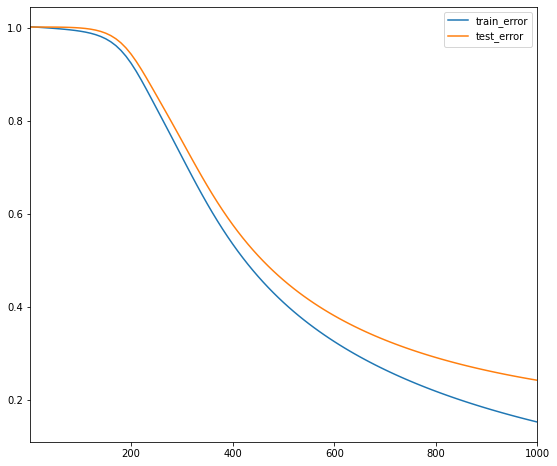

In [ ]:
model_lowinit = build_model(user_artists, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "Oasis", DOT)
artist_neighbors(model_lowinit, "Oasis", COSINE)

## Section V - Regularization in Matrix Factorization

In [ ]:
# @title Solution
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userId": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=0.092004, test_error_observed=0.233604, observed_loss=0.092004, regularization_loss=0.116240, gravity_loss=0.047922

[{'test_error_observed': 0.23360415, 'train_error_observed': 0.09200433},
 {'gravity_loss': 0.047922067,
  'observed_loss': 0.09200433,
  'regularization_loss': 0.11624012}]

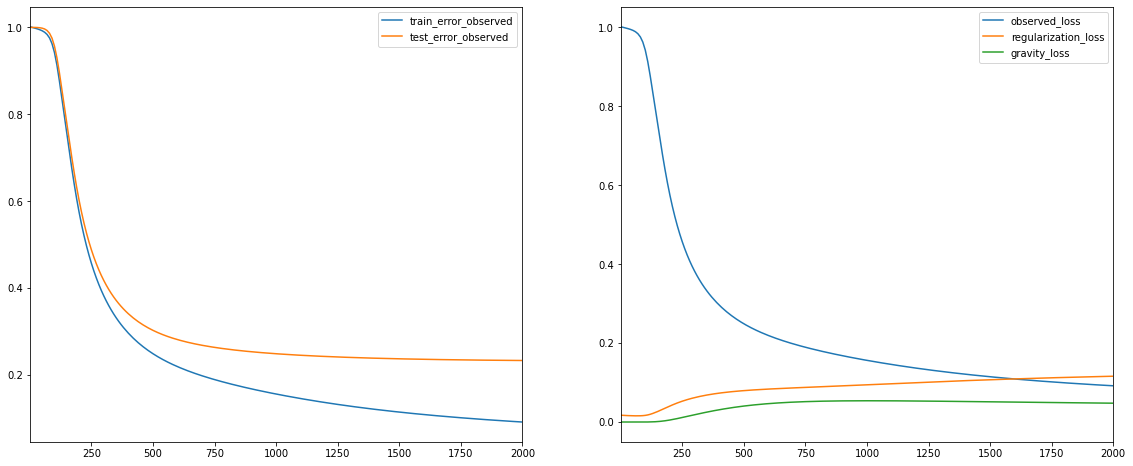

In [ ]:
reg_model = build_regularized_model(
    user_artists, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [ ]:
artist_neighbors(reg_model, "Oasis", DOT)
artist_neighbors(reg_model, "Oasis", COSINE)
artist_neighbors(reg_model, "The Weeknd", DOT)
artist_neighbors(reg_model, "The Weeknd", COSINE)

Nearest neighbors of : Oasis.


dot score           names
10075      2.057        Roy Budd
14247      2.048      Asia Minor
10020      2.040           Sôber
9998       2.034        Guelay74
11765      2.031        Yuna Ito
10287      2.029  Righteous Jams

Nearest neighbors of : Oasis.


cosine score                                       names
527           1.000                                       Oasis
9975          0.952  Satou Rina & Inoue Marina & Chihara Minori
15182         0.950                                 Aylin Aslım
10176         0.949                                 Jazzkantine
8921          0.949                               Rafael Wanyer
11753         0.943                     maria cesilha e rodolfo

Nearest neighbors of : The Weeknd.


dot score                names
9393       0.384        The Melodians
10536      0.381   William Lane Craig
9590       0.379             Big Star
13357      0.375         Ohio Players
13512      0.373      Mickey Lee Lane
2500       0.369  Agnieszka Chylińska

Nearest neighbors of : The Weeknd.


cosine score                          names
5767          1.000                     The Weeknd
5762          0.903                    Group Doueh
5751          0.890                  Don Caballero
13569         0.878                    Invader Zim
1539          0.878          wecamewithbrokenteeth
5754          0.874  Ariel Pink's Haunted Graffiti

Outputting user_artists file for use in next notebook...

In [ ]:
user_artists.to_csv("./data_clean/user_artists.csv", sep=",", header=True, index=False)